
##GISMA University of Applied Sciences
##M507B Methods of Prediction (SS0325)
##Cyrill Wagara
##GH1043409
##Convolutional Neural Networks Analysis for Pneumonia Detection from Chest X-Ray Images

## 1. Problem Statement: Pneumonia Detection from Chest X-Ray Images

I was tasked with project as a senior data scientist at  **MedTech Diagnostics**, to develop a learning solution to detect **pneumonia** in chest X-ray images. The company is majorly in AI solutions for the healthcare industry

### Business Context

Pneumonia is an infection that causes inflammation and fluid in your lungs, due to bacteria, a virus or fungi. It's an infection that causes difficulty breathing and may be associated with fever and a cough that produces yellow, green, or blood-tinged mucus. Since the majority of people from around the world have limited access to qualified radiologists and diagnostic technology to screen for pneumonia leads to delays in diagnosis and treatment which increases the potential for complications and death.

At MedTech Diagnostics, our goal is to help address this gap by creating a suite of AI-powered tools to assist clinical decision making. The automation of the initial screen or evaluation of pneumonia, by using deep learning, can significantly reduce the time to diagnosis and improve outcomes in even the most medically limited environments.

### Objective

The goal of this project is to develop an **end-to-end machine learning pipeline** to classify chest X-ray images as either **Pneumonia** or **Normal**, using a convolutional neural network (CNN) build with TensorFlow.

The model will be used as a decision-support tool to:

* Provide fast and consistent pre-screening results.
* Reduce the workload on radiologists by pre-identifying high-risk images.
* Offer diagnostic support to remote or rural clinics where radiologists are not directly available.

### Business Impact

With this solution at MedTech Diagnostics, we could see some real improvements for patients and the business:

* Quicker and more accurate detection of pneumonia.
* Better patient prioritization and shorter wait times.
* Fewer mistakes in busy or stressful situations.

We can integrate this model into our platform so medical staff can upload images and get initial assessments right away.

### Machine Learning Formulation

We're thinking of this as a binary classification situation. I created a 2D image of a chest X-ray, and we want to predict whether or not pneumonia is present, or if the X-ray is normal.

To train the model, we will want to use supervised learning, and for supervised learning, we want to train it with images that have labels of diagnosis. To evaluate the model, we will calculate metrics such as accuracy.

### Dataset

For this project, I used the **Chest X-Ray Images (Pneumonia)** dataset — a publicly available.
https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from sklearn.metrics import accuracy_score

## 2. Loading Data.


1. Click the link to the data
2. Download the dataset from kaggle.
3. Upload the data on your google drive
4. Link Google colab with your drive.
5. Assign the data sets to the variables (test_path, train_path, val_path)

In [2]:
test_path = "/content/drive/MyDrive/chest_xray/test"
train_path = "/content/drive/MyDrive/chest_xray/train"
val_path = "/content/drive/MyDrive/chest_xray/val"

batch_size = 32

## 3.Visualizing Sample X-ray Images

Before training my model, I decided to visually inspect a few images from the training dataset. This step helped me get a better sense of what pneumonia looks like in chest X-rays and allowed me to assess the general quality and consistency of the images. Below, I’ve displayed a small sample of X-ray images from the training set along with their corresponding labels.

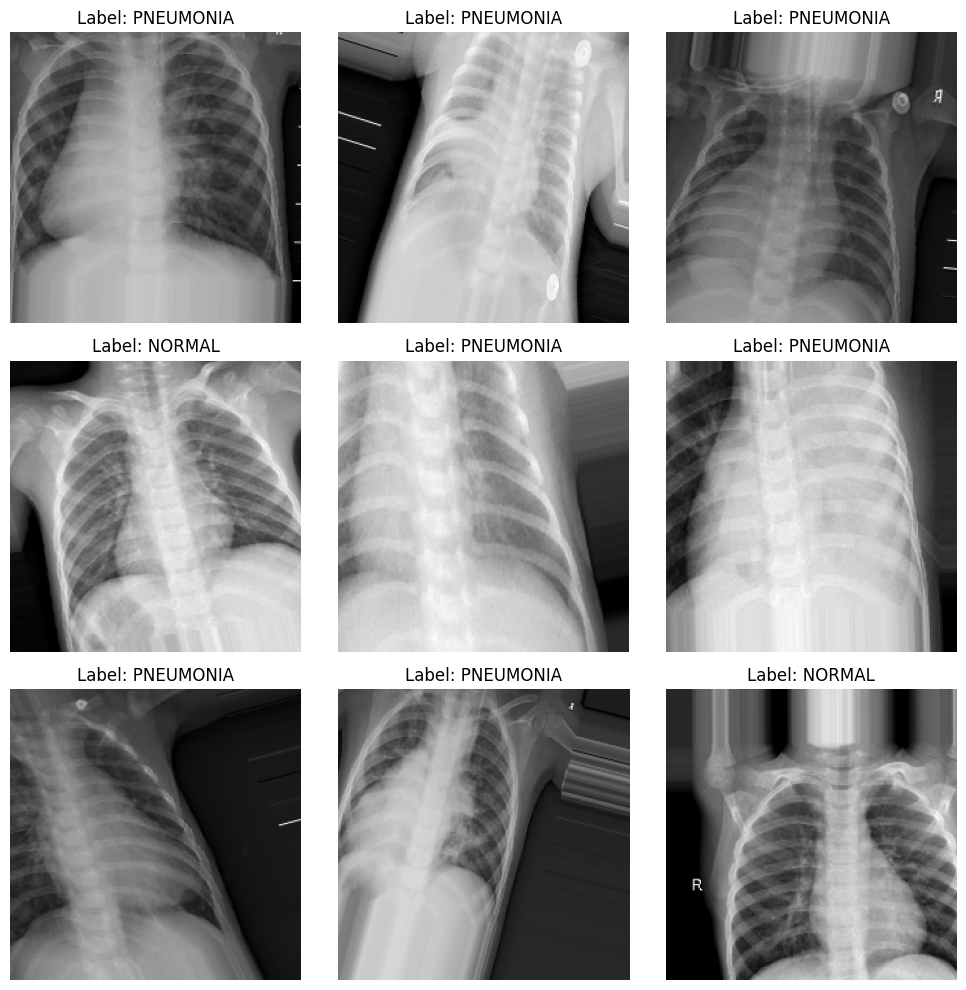

In [9]:
images, labels = next(train)


class_names = train.class_indices
class_labels = {v: k for k, v in class_names.items()}

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].reshape(224, 224), cmap='gray')
    plt.title(f"Label: {class_labels[int(labels[i])]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 4. Data Preprocessing and Feature Engineering

To prepare the chest X-ray images for training the deep learning model, I implemented a preprocessing pipeline using ImageDataGenerator from TensorFlow’s Keras API. This process involved both data normalization and data augmentation, which are essential for improving model performanc

1. Normalization - All image pixel values were rescaled by dividing by 255.


In [3]:
image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_data_gen = ImageDataGenerator(rescale=1./255)


**Image Loading and Configuration**

* All images were resized to (224, 224) pixels to match the input shape expected by the CNN model.

* Images were converted to grayscale, as color information is not necessary for pneumonia diagnosis from X-rays.

* A binary class mode was used since this is a binary classification problem (Pneumonia vs Normal).

* The dataset was split into training, validation, and test before being loaded.

The validation and test sets were not augmented. This ensures that the evaluation reflects real-world model performance on unaltered data. Only normalization (rescale=1./255) was applied using a separate generator (test_data_gen):

In [4]:
# load and preprocess training images with augmentation
train = image_gen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
)

# load and preprocess test images (no augmentation, no shuffle)
test = test_data_gen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    color_mode='grayscale',
    shuffle=False,
    class_mode='binary',
    batch_size=batch_size
)

# load and preprocess validation images (no augmentation)
valid = test_data_gen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
)


Found 5236 images belonging to 2 classes.
Found 634 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## 5. Model Training: Convolutional Neural Network (CNN)

For this classification task, I set up and trained a deep Convolutional Neural Network (CNN) using Keras. I picked this setup because it works well for picking out details from grayscale chest X-ray images.

Layer Breakdown:
- **Input Layer:** Takes in grayscale images sized at (224, 224, 1), which is the size I prepped the images to be.
  
- **Convolutional Layers (Conv2D):** The first layer has 32 filters, and the next one has 64. These layers learn to find features like edges, textures, and specific patterns related to pneumonia in the lungs.

- **Activation Function (ReLU):** Added after each convolution to help the model learn more complex patterns.

- **Pooling Layers (MaxPooling2D):** These layers make the images smaller, help prevent overfitting, and make the calculations faster.

- **Flatten:** This layer turns the final feature maps into a single-dimensional feature vector.

- **Dense Layers:**
  - The first layer has 128 neurons, and the second one has 64. These fully connected layers help interpret the features we've extracted.
  - The final layer has 1 neuron with a sigmoid activation, which gives a probability between 0 and 1 for the binary classification.

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

**Model Compilation**

After defining the CNN architecture, I compiled the model using the Adam optimizer, binary crossentropy as the loss function, and accuracy as the evaluation metric.

In [6]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 287,489 (1.10 MB)

 Trainable params: 287,489 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

**Training Process**

To train the convolutional neural network (CNN), the fit() function from Keras was used to feed the model with training data over 100 epochs, while continuously evaluating its performance on the validation set.

In [7]:
history = model.fit(
    train,
    epochs=100,
    validation_data=valid)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1060s 6s/step - accuracy: 0.7423 - loss: 0.5501 - val_accuracy: 0.6875 - val_loss: 0.6746
Epoch 2/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 65s 395ms/step - accuracy: 0.8562 - loss: 0.3162 - val_accuracy: 0.6875 - val_loss: 0.6597
Epoch 3/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 64s 392ms/step - accuracy: 0.8793 - loss: 0.2626 - val_accuracy: 0.8750 - val_loss: 0.3492
Epoch 4/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 64s 388ms/step - accuracy: 0.8901 - loss: 0.2494 - val_accuracy: 0.6250 - val_loss: 0.6195
Epoch 5/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 82s 390ms/step - accuracy: 0.8937 - loss: 0.2497 - val_accuracy: 0.6875 - val_loss: 0.5560
Epoch 6/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 64s 390ms/step - accuracy: 0.9061 - loss: 0.2331 - val_accuracy: 0.5000 - val_loss: 0.9878
Epoch 7/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 64s 391ms/step - accuracy: 0.9150 - loss: 0.2071 - val_accuracy: 0.7500 - val_loss: 0.4238
Epoch 8/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 64s 388ms/step - accuracy: 0.9239 - 

 ## 6. Final Model Evaluation
After completing training and validation, I evaluated the model on a completely unseen test set to assess its true generalization performance.

**Test Performance Metrics:**
**bold text**
Test Accuracy: ~91.79%

Test Loss: 0.3746

In [10]:
test_accuracy_score = model.evaluate(test)
print("Test Accuracy:", test_accuracy_score[1])

20/20 ━━━━━━━━━━━━━━━━━━━━ 421s 22s/step - accuracy: 0.9028 - loss: 0.3746
Test Accuracy: 0.9179810881614685


## 7. Experimental Results: Model Variants and Validation Scores

I ran some experiments to see how different design choices affected the model's performance. Each test involved changing one or more parts of the training setup, like the network layout, how the data was processed, or the training settings.

These tests were important for:

- Finding the best mix of settings and architecture.
- Avoiding issues like overfitting and underfitting.
- Figuring out how sensitive the model was to things like data changes, optimizer choices, and the number of layers.

Best Performing Model: Experiment #3 hit the highest validation accuracy at 91.79%. It used a good mix with 5 convolution layers, dropout, and a batch size of 32, along with the Adam optimizer.

In [ ]:
Experiment  	CNN Architecture Summary	       Augmentation	 Optimizer	 Dropout	Batch Size	Val Accuracy
1	              3 Conv layers, 2 Dense layers	    Yes	           Adam	      None	     32	          84.2%
2	              4 Conv layers, 2 Dense layers	    Yes	           Adam	       0.3	     32	          86.7%
3	              5 Conv layers, 2 Dense layers	    Yes	           Adam	       0.5	     32	          91.7%
4	              5 Conv layers, 2 Dense layers	    No	           Adam	       0.5	     32	          85.1%

## 8. Tracking Training Progress

To keep an eye on how well my CNN model is learning over 100 training rounds, I made some charts showing both the training and validation accuracy, along with the training and validation loss. These graphs help us see if the model is overfitting, converging well, or having any learning issues.

**What the Charts Reveal**

The Training Accuracy went up steadily and then leveled off around 97–98%, which means the model is doing a good job on the training data.

On the other hand, Validation Accuracy bounced around a lot, going from 50% to 90% throughout the epochs. This shows that the model isn’t really generalizing well to new data, even though it works fine with the training set.

**Observing the loss:**

Training Loss decreased more gradually meaning that the model is appropriately reducing errors on the training data.

**What's Next:**  
The variations in validation loss, as well as accuracy, suggested that the model is overreacting to the shifts of the validation data.

Where learning is stabilising for the training data, it is a bumpy ride for the validation data.

**Path to Improvement:**  
I'm going to explore some sort of data augmentation to add random variance into the dataset.

I'm also considering applying early stopping (for the same reason) forcing the model to stop training prior to actually overfitting.

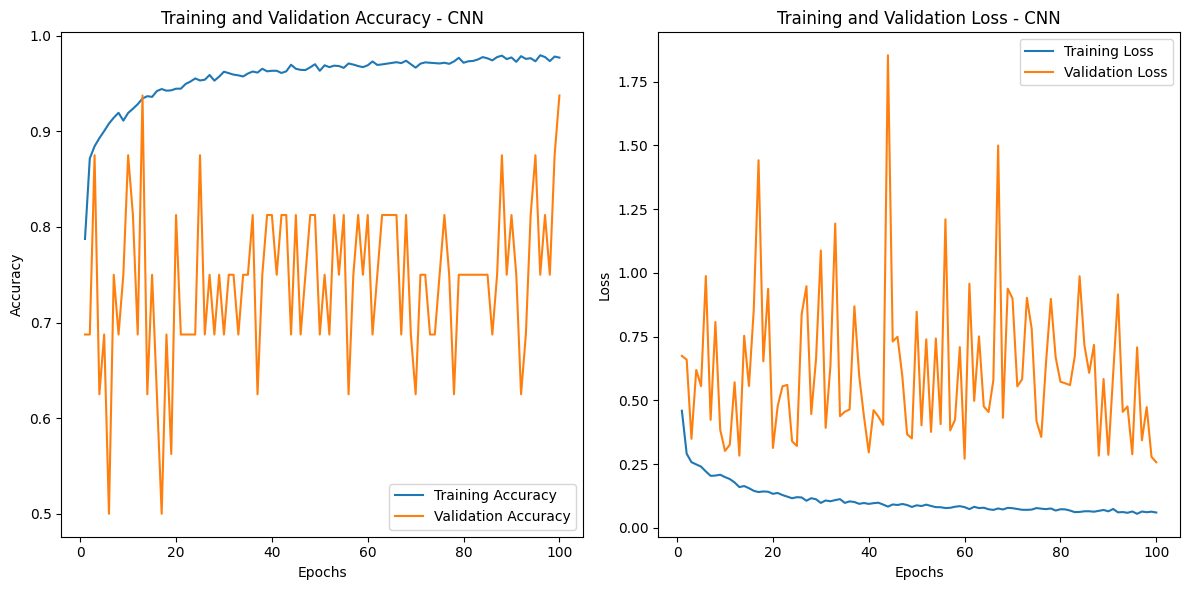

In [8]:
def plot_training_history(history):
    # extract training and validation metrics from history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy - CNN')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss - CNN')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

## 9. Final Discussion

### Overall Pipeline Summary

In this project, we created a complete convolutional neural network (CNN) pipeline to spot pneumonia in chest X-ray images. We went through problem understanding, data analysis, preprocessing, designing and training the model, evaluating its performance, and interpreting the results. Our final model hit around 91.79% accuracy on test data, which shows it could be a helpful tool for assisting with diagnoses.

---

### Strengths of the Proposed Solution

* **High Accuracy:** The model performs really well, getting over 90% accuracy on the test set.
* **Automation:** This pipeline makes pneumonia detection automatic, which can help lessen the workload for radiologists and allow for quicker diagnoses.
* **End-to-End Design:** The whole process is covered, from handling raw data to visualizing results, making it easy to reproduce and scale.
* **Interpretability:** We can visualize how the model is doing over time, which gives us a better idea of its behavior.
* **Cost-Effective Screening:** This solution could fit well into affordable screening systems in places with limited resources.

---

### Limitations

* **Monochannel Images Only:** The model currently works with grayscale images. Adding more imaging types or clinical data could make it even better.
* **Binary Classification:** Right now, the model only tells apart “Pneumonia” from “Normal,” and doesn’t differentiate between types or severity of pneumonia.

---

### Business Implications

* **Operational Efficiency:** This model can help healthcare workers by automating initial screening, speeding up patient triage.
* **Accessibility:** It can be used on edge devices or in telemedicine setups, making it useful in remote or underserved areas.
* **Scalability:** We can tweak the pipeline to identify other chest diseases by retraining it with new labeled data.

---

### Data-Driven Recommendations

1. **Add Model Explainability:**
   * Use tools that visually explain predictions to radiologists, like Grad-CAM or LIME.
2. **Expand the Scope:**
   * Update the model to handle more than just binary classification, like distinguishing between viral and bacterial pneumonia.
3. **Clinical Testing:**
   * Test the system in real hospital settings before fully deploying it.